<a href="https://colab.research.google.com/github/alex-mcintosh/Applying-NLP-for-topic-modelling/blob/main/Applying_NLP_for_topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying NLP for topic modelling

## **Business context**

The PureGym Group, founded in 2008, has approximately 2 million members and 600 gyms across the world (particularly in the UK, Denmark, and Switzerland). As one of the world’s largest value fitness operators, PureGym appeals to a broad range of customers by offering high-quality, low-cost, and flexible fitness facilities. The company’s customer-centric proposition – affordable membership fees, no fixed-term contracts, and 24/7 access to high-quality gyms – differentiates it from more traditional gyms and elevates it as a market leader within this space.

This focus on the customer is centred on wanting to understand what motivates members to join and what factors influence their behaviours once they have joined. Understanding how to leverage innovative technology to influence, improve, and simplify their experience allows PureGym to foster an open, welcoming, and diverse environment for its members while maintaining the value proposition that PureGym is built upon.

With the shift in focus to value-for-money memberships across the gym industry, PureGym seeks to achieve its mission of ‘inspiring a healthier world by providing members with affordable access to the benefits being healthy can offer’.


<br></br>

## **Project Aim**

The project aims to analyse PureGym's customer reviews from Google and Trustpilot to identify key drivers for improving customer experience. Through topic modeling, emotion analysis, and word frequency analysis, the project will uncover common themes in negative reviews and generate actionable recommendations for improvement using advanced models like BERTopic and Phi 3.5 LLM.




# Install Libraries

In [ ]:
!pip install langdetect -q
!pip install bertopic -q
!pip install folium -q
!pip install geopy -q
!pip install gensim nltk datasets pyLDAvis ipykernel -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.0 MB/s eta 0:00:00
ERROR

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from langdetect import detect, LangDetectException
from collections import defaultdict
from bertopic import BERTopic
from umap import UMAP
import folium
from folium import plugins
import branca.colormap as cm
from geopy.geocoders import Nominatim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Helper Functions

Some functions for re-use in the notebook.

In [ ]:
def tidy_text(df, col):
    """
    This takes the data frame (df) and column id (col) to process the text into a
    tokenized format which is output as a new column on df.
    """
    # Convert strings to lower case and remove stopwords
    text = df[col].str.lower()
    stop_words = set(stopwords.words('english'))
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # A custom punctuation string is created as string.punction is not removing the large number of right single quotation marks
    custom_punctuation = string.punctuation + '’'
    # Remove punctuation and numbers
    to_remove = custom_punctuation + string.digits
    translation_table = str.maketrans('', '', to_remove)
    text = text.apply(lambda x: x.translate(translation_table))
    # Tokenize the data and put in a new column
    df['Tokenized_Comment'] = text.apply(word_tokenize)
    return df

In [ ]:
def plot_word_cloud(df, col, title, remove_words):
    """
    Plot the word frequency and word cloud for a given column in a DataFrame.
    col- column of df to plot
    title- title of the plot
    remove_words- list of words to remove from the word count and cloud
    """
    # Flatten the list of lists into a single list of tokens
    flattened_tokens = [token for sublist in df[col] for token in sublist]
    filtered_rev = [word for word in flattened_tokens if len(word) > 2]
    filtered_rev = [word for word in filtered_rev if not word.isnumeric()]
    # Remove selected words that we don't want in our analysis i.e. high frequency words
    # that add little insight (gym, pure etc)
    filtered_rev = [word for word in filtered_rev if word not in remove_words]

    word_distribution = nltk.FreqDist(filtered_rev)
    reviews_word_frequency_distribution_df = pd.DataFrame(word_distribution.most_common(10),
                        columns=['Word', 'Frequency'])

    # Print top ten word from the distribution
    plt.figure(figsize=(10,4))
    sns.set_style("whitegrid")
    ax = sns.barplot(x="Word",
                     y="Frequency",
                     data=reviews_word_frequency_distribution_df.head(10))
    ax.set_title(title)
    plt.figure(figsize = (10,6))
    # Plot the word cloud
    wc = WordCloud(background_color = 'black',
                   colormap='Set2',
                   max_words = 200,
                   max_font_size = 40,
                   width=600,
                   height=300)
    wc.generate(' '.join(filtered_rev))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

In [ ]:
def get_language(text):
    """
    Detects the language of a given text using the langdetect library.
    """
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'  # For when the language is unknown

In [ ]:
def plot_locations_on_map(df, location_col='Location Name',
                          lat_col='Latitude',
                          lon_col='Longitude',
                          metric='Total Reviews'):
    """
    Plots locations from a DataFrame on a Folium map.
        Args:
    df (pd.DataFrame): DataFrame containing location data.
    location_col (str): Column name for location names.
    lat_col (str): Column name for latitude values.
    lon_col (str): Column name for longitude values.
    """
    #drop any rows where Latitude or Logitude are NA
    df = df.dropna(subset=[lat_col, lon_col])
    # Create colourmap index using the quantiles
    index = [df[metric].min(),
             df[metric].quantile(0.25),
             df[metric].quantile(0.5),
             df[metric].quantile(0.75),
             df[metric].max()]
    # Create a colourmap
    step = cm.StepColormap(["green", "yellow", "orange", "red"],
                           vmin=df[metric].min(),
                           vmax=df[metric].max(),
                           index=index,
                           caption=f"{metric} by Quantile")


    # Create a Folium map centered on the median latitude and longitude
    center_lat = df[lat_col].median()
    center_lon = df[lon_col].median()
    map_plot = folium.Map(location=[center_lat, center_lon],
                          zoom_start=6,
                          width = 1000,
                          height = 800)

    # Add markers for each location
    for index, row in df.iterrows():
        folium.Circle(location=[row[lat_col], row[lon_col]],
                      popup=row[location_col],
                      tooltip=row[location_col],
                      radius = 500,
                      fill_color=step(row[metric]),
                      color=step(row[metric]),
                      fill_opacity=1
                    ).add_to(map_plot)

    # Add the colourbar to the map
    map_plot.add_child(step)


    # Display the map
    return map_plot

In [ ]:
def clean(doc):
    """
    Function to clean the document prior to LDA analysis
    """
    # Remove stop words and convert to lowercase.
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    # Remove punctuation.
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # Lemmatise the text.
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Download Data

In [ ]:
# Download datasets
google_url = 'http://drive.google.com/uc?export=download&id=13TeZTT6oqk3iPELBhFx9hComIfChKw4m'
TP_url = 'https://drive.google.com/uc?export=download&id=1V6Pr6xWrHSHaothB61MJbR7mPFHwQ1u6'

google_rev = pd.read_excel(google_url)
TP_rev = pd.read_excel(TP_url)

# Initial Data Exploration

In [ ]:
print(google_rev.shape)
google_rev.head(2)

(23250, 7)


Customer Name SurveyID for external use (e.g. tech support)  \
0            **                      ekkt2vyxtkwrrrfyzc5hz6rk   
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   

               Club's Name Social Media Source       Creation Date  \
0  Leeds City Centre North      Google Reviews 2024-05-09 23:49:18   
1   Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   

                                             Comment  Overall Score  
0                                                NaN              4  
1  Too many students from two local colleges go h...              1

In [ ]:
print(TP_rev.shape)
TP_rev.head(2)

(16673, 15)


Review ID Review Created (UTC)   Review Consumer User ID  \
0  663d40378de0a14c26c2f63c  2024-05-09 23:29:00  663d4036d5fa24c223106005   
1  663d3c101ccfcc36fb28eb8c  2024-05-09 23:11:00  5f5e3434d53200fa6ac57238   

                    Review Title  \
0        A very good environment   
1  I love to be part of this gym   

                                      Review Content  Review Stars  \
0                            A very good environment             5   
1  I love to be part of this gym. Superb value fo...             5   

  Source Of Review Review Language              Domain URL Webshop Name  \
0            AFSv2              en  http://www.puregym.com   PureGym UK   
1            AFSv2              en  http://www.puregym.com   PureGym UK   

           Business Unit ID  Tags Company Reply Date (UTC)  \
0  508df4ea00006400051dd7b1   NaN      2024-05-10 08:12:00   
1  508df4ea00006400051dd7b1   NaN      2024-05-10 08:13:00   

                Location Name                           Location ID  
0  Solihull Sears Retail Park  7b03ccad-4a9d-4a33-9377-ea5bba442dfc  
1                   Aylesbury  612d3f7e-18f9-492b-a36f-4a7b86fa5647

### Data Cleaning

To allow easier use the dataframes will be tidied to remove columns that are not useful and missing rows.

In [ ]:
# Remove rows with missing values in the Comment column of google_rev
google_rev = google_rev.dropna(subset=['Comment'])

# Remove columns from google reviews which are not needed
google_rev = google_rev.drop(columns = ['Customer Name',
                                        'SurveyID for external use (e.g. tech support)',
                                        'Social Media Source'])

# Remove rows with missing values in the Review Content column of TP_rev
TP_rev = TP_rev.dropna(subset=['Review Content'])

In [ ]:
# Remove columns from google reviews which are not needed
TP_rev = TP_rev.drop(columns = ['Review ID',
                                'Review Consumer User ID',
                                'Source Of Review',
                                'Domain URL',
                                'Webshop Name',
                                'Business Unit ID',
                                'Tags',])

print('google_rev size:', google_rev.shape)
print('TP_rev size:', TP_rev.shape)

google_rev size: (13898, 4)
TP_rev size: (16673, 8)


Intrestingly there is a significant number of records (~40%) in the Google reviews where no comment has been left. It is assumed here customers are reviewing by leaving just a star rating.

In [ ]:
# Find number of unique Club Names in the Google Reviews
google_rev["Club's Name"].value_counts()

Club's Name
Elkridge                         198
Springfield                      194
Manchester Market Street         134
Tysons Corner                    125
Leeds Bramley                    105
                                ... 
136 - Greve, Håndværkerbyen        1
268 - Odense, Sankt Hans Gade      1
186 - Stenløse, Rådhustorvet       1
232 - Højbjerg                     1
251 - Busgaden, Århus              1
Name: count, Length: 512, dtype: int64

There are 512 unique club names in the Google review data.

In [ ]:
# Find number of unique Location Names in the Trustpilot Reviews
TP_rev["Location Name"].value_counts()

Location Name
345                          174
London Park Royal            137
Leicester Walnut Street       83
Doncaster                     77
Burnham                       72
                            ... 
Northallerton                  8
Walsall                        7
London Greenwich Movement      5
London Tower Hill              2
Tonbridge                      1
Name: count, Length: 376, dtype: int64

There are 376 unique location names in the Trustpilot review data.

In [ ]:
# Find Gym locations common to both sets
google_locations = google_rev["Club's Name"].unique()
google_locations = google_locations.astype(str)
google_locations_sorted = np.sort(google_locations)

TP_locations = TP_rev["Location Name"].unique()
TP_locations = TP_locations.astype(str)
TP_locations_sorted = np.sort(TP_locations)
intersection_of_locations = [e for e in TP_locations if e in google_locations]
len(intersection_of_locations)

310

310 gyms are common to both datasets.

### Language

Here the languages used in the comments is examined. When using BERTopic some languages (even when using 'Multilingual') seemed to exert a strong influence on the classification. These non-english reviews will be removed.

In [ ]:
#print unique entries in TP_rev['Review Language']
TP_rev['Review Language'].value_counts().head(10)

Review Language
en    16581
da       34
pl        9
pt        9
es        9
it        6
ro        6
fr        4
de        4
bg        1
Name: count, dtype: int64

Studying the language column for the Trustpilot reviews, it is observed that the vast majority of the reviews are in English (99.4%). The non-english language comments will be dropped for simplicity.

In [ ]:
# Due to the low number of non-english reviews these will be removed
TP_rev = TP_rev[TP_rev['Review Language'] == 'en']
TP_rev.shape

(16581, 8)

No language is specified for the Google Review so a customer function is used.



In [ ]:
# Detect language and language code to new 'Review Language' field
google_rev['Review Language'] = google_rev['Comment'].apply(get_language)

In [ ]:
google_rev['Review Language'].value_counts().head(10)

Review Language
en    11868
da      451
de      397
cy      323
fr      132
af       74
ca       72
so       61
es       54
no       50
Name: count, dtype: int64

Comments in english make up ~ 85.3 % of the reviews. Although language detection is not 100% the non-english comments will be dropped in this instance to make analysis simpler.

In [ ]:
google_rev = google_rev[google_rev['Review Language'] == 'en']
google_rev.shape

(11868, 5)

### Text pre-processing

In [ ]:
# Tidy up text by removing stopwords, , numbers, changing to lower case and tokenizing
google_rev = tidy_text(google_rev, 'Comment')
TP_rev = tidy_text(TP_rev, 'Review Content')

In [ ]:
google_rev.head(2)

Club's Name       Creation Date  \
1  Cambridge Leisure Park 2024-05-09 22:48:39   
2          London Holborn 2024-05-09 22:08:14   

                                             Comment  Overall Score  \
1  Too many students from two local colleges go h...              1   
2  Best range of equipment, cheaper than regular ...              5   

  Review Language                                  Tokenized_Comment  
1              en  [many, students, two, local, colleges, go, lea...  
2              en  [best, range, equipment, cheaper, regular, gym...

In [ ]:
TP_rev.head(2)

Review Created (UTC)                   Review Title  \
0  2024-05-09 23:29:00        A very good environment   
1  2024-05-09 23:11:00  I love to be part of this gym   

                                      Review Content  Review Stars  \
0                            A very good environment             5   
1  I love to be part of this gym. Superb value fo...             5   

  Review Language Company Reply Date (UTC)               Location Name  \
0              en      2024-05-10 08:12:00  Solihull Sears Retail Park   
1              en      2024-05-10 08:13:00                   Aylesbury   

                            Location ID  \
0  7b03ccad-4a9d-4a33-9377-ea5bba442dfc   
1  612d3f7e-18f9-492b-a36f-4a7b86fa5647   

                                   Tokenized_Comment  
0                                [good, environment]  
1  [love, part, gym, superb, value, money, time, ...

### Visualisation of common words and topics in all the reviews.

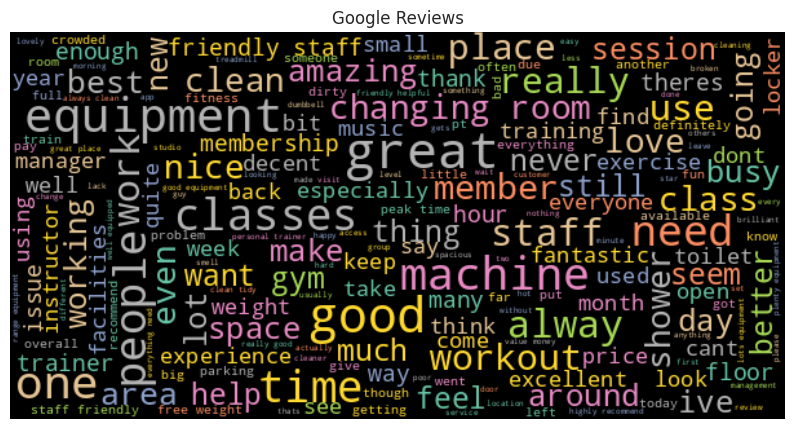

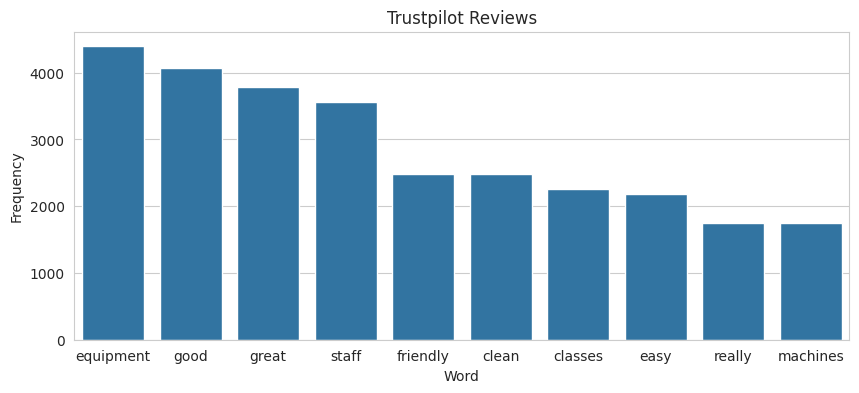

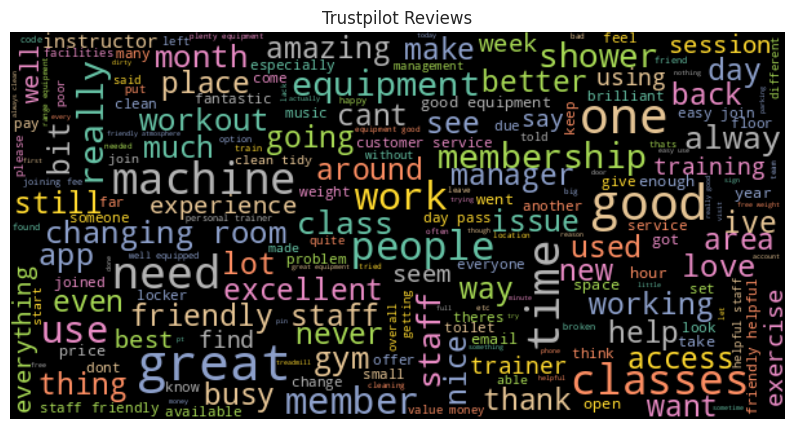

In [ ]:
# Remove some custom common words that add little insight to the analysis
custom_list = 'gym' + 'puregym' + 'pure'
# Plot frequency and word clouds
plot_word_cloud(google_rev, 'Tokenized_Comment', 'Google Reviews', custom_list)
plot_word_cloud(TP_rev, 'Tokenized_Comment', 'Trustpilot Reviews', custom_list)

In both datasets, the top words include 'equipment', 'good', 'great', and 'staff'. From this simple analysis, it is difficult to identify key topics and insights as there is little context and sentiment to the words. For example, does equipment relate to a lack of equipment or poorly maintained equipment, and are the words associated with complaints or compliments? This makes identifying actionable insights difficult.

### Visualisation of common words and topics in bad reviews (< 3 stars)

Isolating reviews with 3 or less stars, allows us to narrow down the sentiment of the words, assuming that the lower stars correlate with negative emotions. This may give more insight as to why customers may be unhappy.

In [ ]:
# Create new dataframe for Google reviews with just bad reviews (i.e. Overall Score < 3)
bad_google_rev = google_rev[google_rev['Overall Score'] < 3]
# Create new dataframe for Trustpilot reviews with just bad reviews (i.e. Review Stars < 3)
bad_TP_rev = TP_rev[TP_rev['Review Stars'] < 3]
print('bad_google_rev size:', bad_google_rev.shape)
print('bad_TP_rev size:', bad_TP_rev.shape)

bad_google_rev size: (2422, 6)
bad_TP_rev size: (3508, 9)


This has led to a significant reduction in the size of the datasets.

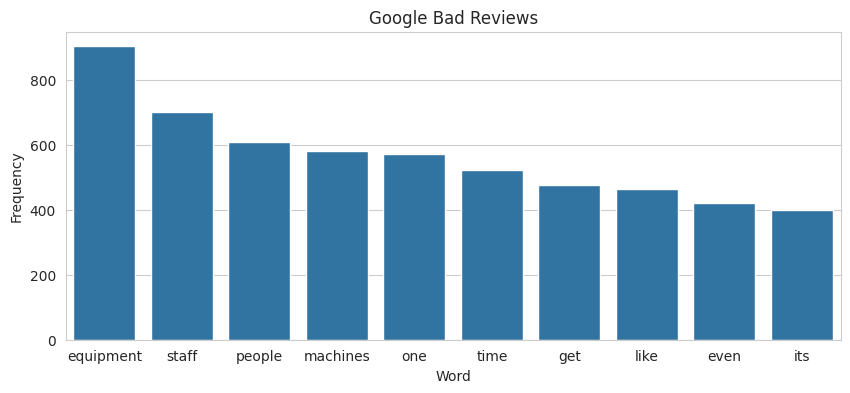

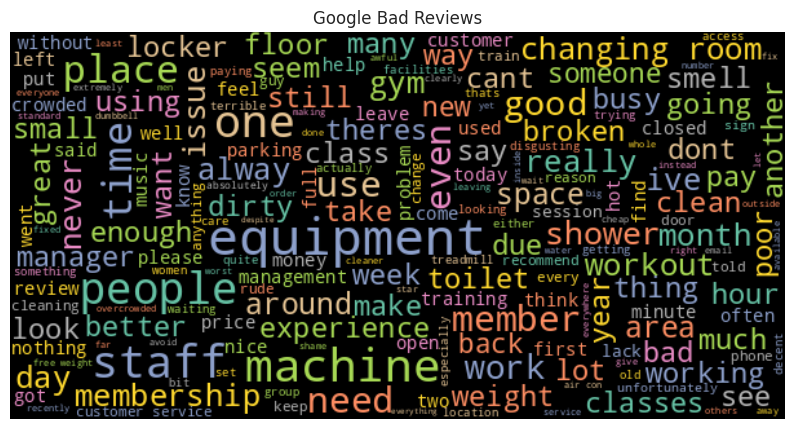

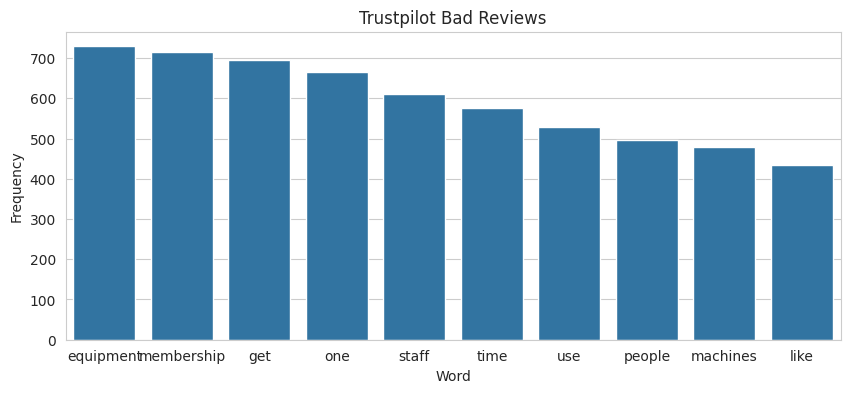

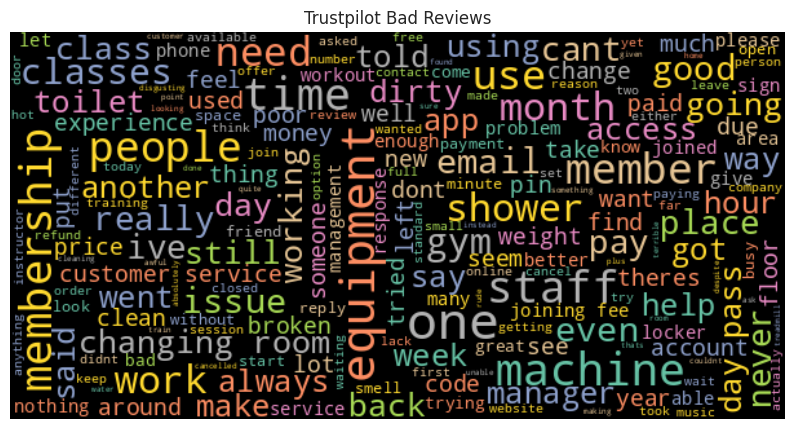

In [ ]:
# Create new word frequency and word clouds for the bad reviews
plot_word_cloud(bad_google_rev, 'Tokenized_Comment', 'Google Bad Reviews', custom_list)
plot_word_cloud(bad_TP_rev, 'Tokenized_Comment', 'Trustpilot Bad Reviews', custom_list)

Selecting just the bad reviews allows slightly more insight. The common words seen before 'great' and 'good' have, as would be expected, disappeared. While 'equipment' and 'staff' reappear alongside 'membership', 'people' and 'staff'. This filtering on sentiment allows some more insight in that complaints may group around poor/inadequate gym equipment and interactions with staff members and other gym users. However looking at words in isolation makes it difficult to obtain context and identify topics and further insights.

# Topic Modelling

Here topic modelling will be investigated. Firstly the comments in both datasets will be merged to those gym locations common to both datsets.

In [ ]:
# Filter google_rev based on intersection_of_locations generated earlier
bad_google_rev_loc = bad_google_rev[bad_google_rev["Club's Name"].isin(intersection_of_locations)]
# Filter TP_rev based on intersection_of_locations generated earlier
bad_TP_rev_loc = bad_TP_rev[bad_TP_rev["Location Name"].isin(intersection_of_locations)]

In [ ]:
# Merge the two datasets into a bad reviews dataset
bad_reviews = bad_google_rev_loc['Comment'].astype(str).to_list()
bad_reviews.extend(bad_TP_rev_loc['Review Content'].astype(str).to_list())
len(bad_reviews)

3884

In [ ]:
# Create umap_model to seed and make the results consistent during the creation of the notebook
umap_model = UMAP(random_state=42)
model1 = BERTopic(verbose=True, umap_model=umap_model)
model1.fit(bad_reviews)
topic, probabilities = model1.transform(bad_reviews)

2024-11-19 20:48:58,403 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

2024-11-19 20:49:06,197 - BERTopic - Embedding - Completed ✓
2024-11-19 20:49:06,198 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-19 20:49:32,465 - BERTopic - Dimensionality - Completed ✓
2024-11-19 20:49:32,466 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-19 20:49:32,567 - BERTopic - Cluster - Completed ✓
2024-11-19 20:49:32,572 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-19 20:49:32,859 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/122 [00:00<?, ?it/s]

2024-11-19 20:49:34,722 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-19 20:49:34,735 - BERTopic - Dimensionality - Completed ✓
2024-11-19 20:49:34,736 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-19 20:49:34,860 - BERTopic - Cluster - Completed ✓


In [ ]:
# List the topics and their frequencies
model1.get_topic_info().head(11)

Topic  Count                             Name  \
0      -1   1530                 -1_the_to_and_of   
1       0    199                  0_to_me_and_her   
2       1    182            1_cleaning_the_and_is   
3       2    135                 2_air_hot_ac_con   
4       3    127          3_parking_car_park_free   
5       4    116      4_showers_shower_cold_water   
6       5     84           5_price_is_the_puregym   
7       6     74      6_fee_my_membership_account   
8       7     71          7_music_loud_noise_hear   
9       8     71  8_equipment_broken_machines_out   
10      9     70             9_pass_day_pin_didnt   

                                       Representation  \
0       [the, to, and, of, gym, is, in, for, are, it]   
1   [to, me, and, her, she, the, he, this, staff, ...   
2   [cleaning, the, and, is, gym, of, in, to, this...   
3   [air, hot, ac, con, the, is, conditioning, its...   
4   [parking, car, park, free, fine, you, to, the,...   
5   [showers, shower, cold, water, the, hot, to, a...   
6   [price, is, the, puregym, gym, and, for, of, t...   
7   [fee, my, membership, account, joining, charge...   
8   [music, loud, noise, hear, volume, headphones,...   
9   [equipment, broken, machines, out, old, not, m...   
10  [pass, day, pin, didnt, code, bought, paid, to...   

                                  Representative_Docs  
0   [I gave you 5* exactly a year ago but it just ...  
1   [Avoid this gym if you want to exercise in a f...  
2   [One star is even being generous . I’ve been g...  
3   [Air con seems to be a big issue. It’s very un...  
4   [Such a shame to have to write the review beca...  
5   [When I first joined PureGym the showers were ...  
6   [Pros:\n- It's a new gym, so everything is new...  
7   [Just a heads up, be careful when cancelling o...  
8   [Simply gave up with this gym . Have done ther...  
9   [Broken windows, broken water machine, broken ...  
10  [Free day pass not working, Bought a day pass ...

#### Topic 0

In [ ]:
# Output information about the first topic
print(model1.get_representative_docs(0)[0])
model1.get_topic(0)

Avoid this gym if you want to exercise in a friendly and clean space!! They deleted my review on Trustpilot, so I’m writing again. The gym manager at Pure Gym Stratford is extremely rude, unprofessional and really loves power plays. After I incorrectly replaced my dumbbells on the wrong shelves, she not only humiliated me by raising her voice publicly, but she also proceeded to suspend my gym membership when I told her that she cannot raise her voice to me in front of everyone. After 2 weeks and hundreds of emails, I was able to get my membership back after a meeting with the cluster manager. He understood my concerns about her and definitely had a more friendly and professional vibe.  When I returned to the gym after 2 weeks, I saw that a lot of dumbbells were placed on the wrong shelves there. She was around but wasn't warning anyone the way she raised her voice at me. The reason why my account was suspended is because I didn’t let her raise her voice against me. She should know how 

[('to', 0.017900086026367883),
 ('me', 0.017623928673104135),
 ('and', 0.017177711062573167),
 ('her', 0.01598605400262188),
 ('she', 0.015460032310372273),
 ('the', 0.015138038506454779),
 ('he', 0.01506419238011885),
 ('this', 0.014015361841285745),
 ('staff', 0.013813964968220398),
 ('gym', 0.0137739732046266)]

This topic appears to relate to staff interactions, with the words staff and several pronouns.



#### Topic 1

In [ ]:
# Output information about the second topic
print(model1.get_representative_docs(1)[0])
model1.get_topic(1)

One star is even being generous . I’ve been going to this gym for a while . I decided to do a class as I hadn’t done one at this gym before . I’m assuming it is the same regular people who do the classes as they all knew what they needed equipment wise . When I walked in , the man with the tattooed face did not introduce himself or even say hi , he didn’t tell me what equipment I needed and rather left it up to someone else in the class to tell me . Didn’t explain to me how the class would go , did not explain certain exercises to me when you could clearly see I was confused . He obviously doesn’t care about his job or helping the people taking part in the classes . Not only this but the hygiene of the gym is disgusting , there was no soap in the ladies toilets for about a month . I never see a cleaner and the one time I did see a cleaner she was sitting on her phone in the changing rooms and not actually cleaning . The toilets downstairs flooded and the floors in the gym were soaking 

[('cleaning', 0.02041300485231713),
 ('the', 0.019523401794228252),
 ('and', 0.016334788022580937),
 ('is', 0.016011660498516017),
 ('gym', 0.015914704853235945),
 ('of', 0.015121598180123721),
 ('in', 0.014930998381724327),
 ('to', 0.013550882702676764),
 ('this', 0.012467729717756233),
 ('are', 0.012123384197198878)]

This topic appears to relate to the cleanliness. With a count of 182 this is close in frequency to the top complaint around staff interactions.





In [ ]:
# Plot intertopic distances
model1.visualize_topics(top_n_topics=30)

In [ ]:
# Plot top words for each topic
model1.visualize_barchart()

In [ ]:
# Plot heatmap for topics
model1.visualize_heatmap(top_n_topics=10)

A large number (1530) of reviews appear to be classified as outliers. These seem to relate to stopwords. They were included to add context; for comparison, it would be interesting to run BERTopic without these.

The top topics that appear to be identified include:

* Topic 0 - Staff interactions.
* Topic 1 - Cleanliness.
* Topic 2 - Temperature/comfort, specifically A/C and hot temperatures.
* Topic 3 – Parking and fines relating to parking are also in this topic.
* Topic 4 - Showers and cold water—Words such as shower, cold, hot, water, and temperature appear here.
* Topic 5 - Pricing
* Topic 6 - Memberships and payment – Words such as cancel, account, charging, and suspended appear, suggesting problems with memberships and payments.
* Topic 7 - Music and noise—This topic concerns loud noises and music. The word "classes" appears here, suggesting it may be specifically related to classes.
* Topic 8 - Broken equipment—Words such as old, poor, and broken appear alongside equipment and machines.
* Topic 9 - Access codes and day passes. Words such as pass, day, pin, code, paid, and bought suggest this may be related to day passes.

The heatmap suggests the following topic relationships:
* Membership fees and day passes
* Pricing and cleanliness
* Shower temperature and cleanliness
* Cleanliness and staff interactions




# Further data investigation


It is interesting to look at the location of the bad reviews for Google and Trustpilot reviews

In [ ]:
# Create new dataframe for reviews by location
bad_google_rev_by_location = bad_google_rev.copy()
bad_google_rev_by_location = bad_google_rev_by_location[["Club's Name"]]
# Drop records without a location name
bad_google_rev_by_location = bad_google_rev_by_location.dropna()
# Group by location name, count and sort
bad_google_rev_by_location = bad_google_rev_by_location.groupby(["Club's Name"])["Club's Name"].count().reset_index(name='total_count_google')
bad_google_rev_by_location_sorted = bad_google_rev_by_location.sort_values(by=['total_count_google'], ascending=False)

In [ ]:
# Output top 20 locations with the most reviews under 3 stars on Google
bad_google_rev_by_location_sorted.head(20)

Club's Name  total_count_google
248          London Stratford                  59
259           London Woolwich                  26
205       London Canary Wharf                  26
215            London Enfield                  24
240      London Palmers Green                  22
250      London Swiss Cottage                  22
232        London Leytonstone                  21
60     Birmingham City Centre                  20
73         Bradford Thornbury                  19
367                 Wakefield                  18
226             London Hoxton                  18
307   Peterborough Serpentine                  18
281                New Barnet                  18
223              London Hayes                  17
244      London Seven Sisters                  17
269  Manchester Exchange Quay                  17
368       Walsall Crown Wharf                  17
298        Nottingham Colwick                  16
236       London Muswell Hill                  15
242         London Piccadilly                  15

In [ ]:
# Create new dataframe for reviews by location
bad_TP_rev_by_location = bad_TP_rev.copy()
bad_TP_rev_by_location = bad_TP_rev_by_location[["Location Name"]]
# Drop records without a location name
bad_TP_rev_by_location = bad_TP_rev_by_location.dropna()
# Group by location name, count and sort
bad_TP_rev_by_location = bad_TP_rev_by_location.groupby(["Location Name"])["Location Name"].count().reset_index(name='total_count_tp')
bad_TP_rev_by_location_sorted = bad_TP_rev_by_location.sort_values(by=['total_count_tp'], ascending=False)

In [ ]:
# Output top 20 locations with the most reviews under 3 stars on Trustpilot
bad_TP_rev_by_location_sorted.head(20)

Location Name  total_count_tp
155    Leicester Walnut Street              50
0                          345              45
186             London Enfield              23
219           London Stratford              22
58                     Burnham              20
199              London Ilford              18
171          London Bermondsey              18
195               London Hayes              16
188            London Finchley              16
215       London Seven Sisters              16
358                       York              16
233                 Maidenhead              16
194  London Hammersmith Palais              15
261                  Northwich              15
221       London Swiss Cottage              15
30      Birmingham City Centre              14
95               Dudley Tipton              14
19                    Basildon              14
343        Watford Waterfields              14
330                    Telford              14

Both Google and Trustpilot reviews have a high number of bad reviews relating to gyms in big cities. London features heavily in both, which is unsurprising given the location's potential high usage and the cost of commercial floor space in the city.

For the Google reviews, the London Stratford gym has a significantly higher number of bad reviews, over twice as many as the next gym.
For the Trustpilot reviews, the Leicester Walnut Street gym and a gym called '345' have double the complaints of the following gyms.

With more time it would be pertinent to focus on these gyms to identify where they may be failing customers.

In [ ]:
# Merge the locations into a common dataset
bad_reviews_merged_location = pd.merge(
                        bad_TP_rev_by_location_sorted,
                        bad_google_rev_by_location_sorted,
                        how='inner', left_on='Location Name',
                        right_on="Club's Name"
                        )
bad_reviews_merged_location["Total Reviews"] = (
                                    bad_reviews_merged_location["total_count_tp"]
                                    + bad_reviews_merged_location["total_count_google"]
                                                )
bad_reviews_merged_location = bad_reviews_merged_location.sort_values(by=["Total Reviews"], ascending=False)
bad_reviews_merged_location

Location Name  total_count_tp              Club's Name  \
2           London Stratford              22         London Stratford   
0    Leicester Walnut Street              50  Leicester Walnut Street   
1             London Enfield              23           London Enfield   
12      London Swiss Cottage              15     London Swiss Cottage   
13    Birmingham City Centre              14   Birmingham City Centre   
..                       ...             ...                      ...   
272   Southend Fossetts Park               1   Southend Fossetts Park   
254              London Bank               2              London Bank   
274                  Consett               1                  Consett   
276        Glasgow Milngavie               1        Glasgow Milngavie   
269               Altrincham               1               Altrincham   

     total_count_google  Total Reviews  
2                    59             81  
0                    11             61  
1                    24             47  
12                   22             37  
13                   20             34  
..                  ...            ...  
272                   2              3  
254                   1              3  
274                   2              3  
276                   1              2  
269                   1              2  

[287 rows x 5 columns]

In [ ]:
# Assign latitudes and longitudes to the locations in the merged dataset.
lat = []
long = []


# Initialise the geocoder
loc = Nominatim(user_agent="abcd")
for index, row in bad_reviews_merged_location.iterrows():
    # add ', UK' to location values as it geocode missasigns some strings
    getLoc = loc.geocode(row["Location Name"] + ', UK')
    if getLoc is not None:
        lat.append(getLoc.latitude)
        long.append(getLoc.longitude)
    else:
        lat.append(None)
        long.append(None)
# Assign lat and long to the dataframe of reviews
bad_reviews_merged_location['Location Name'] = bad_reviews_merged_location['Location Name']
bad_reviews_merged_location['Latitude'] = lat
bad_reviews_merged_location['Longitude'] = long

In [ ]:
# Plot these bad reviews to a map
map_plot = plot_locations_on_map(bad_reviews_merged_location)
map_plot

The map further emphasises the higher numbers of bad reviews for gyms in the larger cities e.g. London and Birmigham.

In [ ]:
# Reduce this to the top 30 locations with reviews of < 3 stars
top_30 = bad_reviews_merged_location.head(30)["Location Name"]
filtered_bad_google_rev = bad_google_rev[bad_google_rev["Club's Name"].isin(top_30)]
filtered_bad_google_rev.shape

(516, 6)

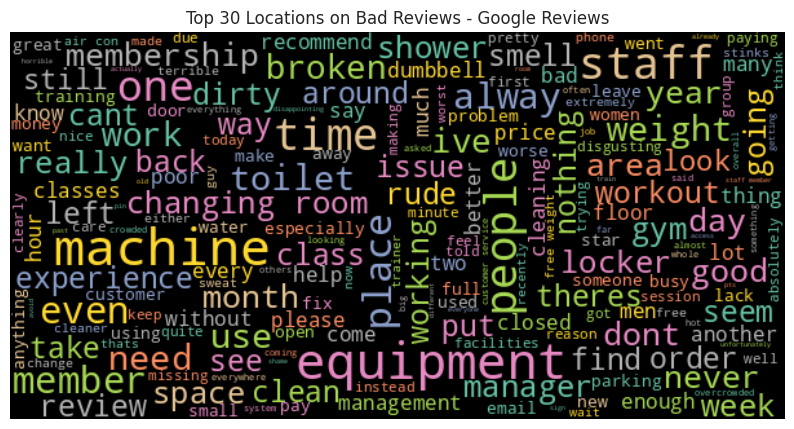

In [ ]:
# Plot word frequency and word cloud for the top 30 locations with the most Google reviews < 3 stars
custom_list = 'gym' + 'puregym' + 'pure'
plot_word_cloud(filtered_bad_google_rev, 'Tokenized_Comment',
                'Top 30 Locations on Bad Reviews - Google Reviews', custom_list)

This is very similar to the word counts and word clouds seen for bad Google Reviews across all locations above.
Equipment, staff, people, and machines are still in the top four, suggesting that the top 30 locations are fairly representative of bad reviews across many locations.

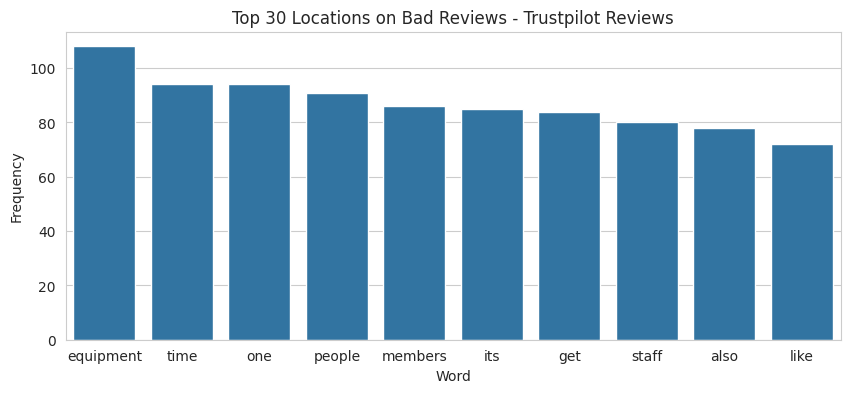

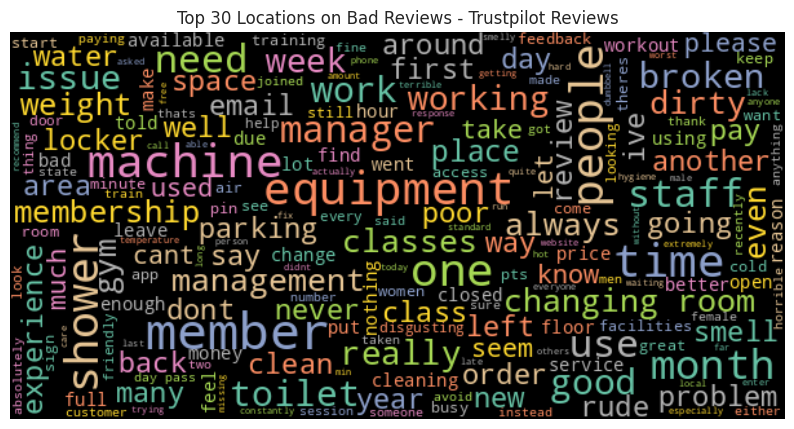

In [ ]:
# Plot word frequency and word cloud for the top 30 locations with the most Trustpilot reviews of < 3 stars
filtered_bad_TP_rev = bad_TP_rev[bad_TP_rev["Location Name"].isin(top_30)]
plot_word_cloud(filtered_bad_TP_rev, 'Tokenized_Comment',
                'Top 30 Locations on Bad Reviews - Trustpilot Reviews', custom_list)

This is also very similar to the word counts and word clouds seen for bad Trustpilot Reviews across all locations [above.](https://colab.research.google.com/drive/1Mar04XlMDlaUKXW-COyvFixXKgvBlBTe#scrollTo=_v0b90ho23Xx&line=1&uniqifier=1)
However, the word 'membership' is not as prominent now relative to other top words.

In [ ]:
# Merge the two datasets into a 'top 30 bad' dataset
filtered_bad_reviews = filtered_bad_google_rev['Comment'].astype(str).to_list()
filtered_bad_reviews.extend(filtered_bad_TP_rev['Review Content'].astype(str).to_list())

In [ ]:
# Undertake BERTopic analysis on this merged top 30 dataset. Change min_topic_size from default of 10 to 3.
model2 = BERTopic(verbose=True, min_topic_size = 3, umap_model=umap_model)
model2.fit(filtered_bad_reviews)
topic2, probabilities2 = model2.transform(filtered_bad_reviews)

2024-11-19 21:24:53,635 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2024-11-19 21:24:55,082 - BERTopic - Embedding - Completed ✓
2024-11-19 21:24:55,083 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-19 21:24:57,348 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:24:57,350 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-19 21:24:57,389 - BERTopic - Cluster - Completed ✓
2024-11-19 21:24:57,393 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-19 21:24:57,538 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2024-11-19 21:24:58,192 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-19 21:24:58,197 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:24:58,197 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-19 21:24:58,225 - BERTopic - Cluster - Completed ✓


In [ ]:
# Output top 10 topics
model2.get_topic_info().head(10)

Topic  Count                            Name  \
0     -1    207                -1_the_and_in_to   
1      0     43           0_parking_car_85_free   
2      1     37  1_machine_machines_months_been   
3      2     30     2_broken_equipment_too_busy   
4      3     28                 3_her_she_me_he   
5      4     24       4_toilet_toilets_no_staff   
6      5     23  5_class_classes_was_instructor   
7      6     22      6_fee_cancel_payment_month   
8      7     20       7_weights_gym_around_very   
9      8     17       8_water_yanga_sports_fill   

                                      Representation  \
0      [the, and, in, to, gym, is, of, for, are, it]   
1  [parking, car, 85, free, fines, park, reg, you...   
2  [machine, machines, months, been, fix, for, of...   
3  [broken, equipment, too, busy, equipments, mac...   
4  [her, she, me, he, was, to, member, gym, voice...   
5  [toilet, toilets, no, staff, changing, room, c...   
6  [class, classes, was, instructor, booked, that...   
7  [fee, cancel, payment, month, charged, was, jo...   
8  [weights, gym, around, very, small, youre, mor...   
9  [water, yanga, sports, fill, working, fountain...   

                                 Representative_Docs  
0  [Something has to change! For the last 2 years...  
1  [As several others have mentioned, members are...  
2  [The only reason it's not a 1 is because there...  
3  [Broken light keeps flashing which is very tir...  
4  [Avoid this gym if you want to exercise in a f...  
5  [The changing room constantly smells horribly ...  
6  [I booked a stretch class for 1530 on Septembe...  
7  [Hello, good evening, I am a new member of you...  
8  [This is honestly, one of the worst gyms I hav...  
9  [The Yanga sports water dispenser has been out...

In [ ]:
# Output examples of words and reviews for the first topic
print(model2.get_representative_docs(0)[0])
model2.get_topic(0)

As several others have mentioned, members are never told to register their car reg every time they enter the gym. As a result several members have received parking charges of £85.  The management never took responsibility when it is clearly evident that 1) no free parking is allowed at the only available access to the gym and 2) no mention of the parking situation is included in the joining instructions and terms. Instead, when the problem emerged, management silently added A4 paper with warning about the need to enter the car reg at a tablet that is almost hidden behind a wall. Do not waste your time, money and above all sanity to become a member. I am cancelling mine.


[('parking', 0.07007259474265969),
 ('car', 0.02651341315517421),
 ('85', 0.022889143630585435),
 ('free', 0.02192908613277624),
 ('fines', 0.02067659377490998),
 ('park', 0.018117050373928637),
 ('reg', 0.017952433097346454),
 ('your', 0.016242630232306283),
 ('to', 0.015179935230790923),
 ('website', 0.0150273536076479)]

In [ ]:
# Output examples of words and reviews for the second topic
print(model2.get_representative_docs(1)[0])
model2.get_topic(1)

The only reason it's not a 1 is because there aren't many other options. Overpriced and with a lack of equipment compared to other units, which also limits the variety. The space is big but it boils down to number of equipments per exercise, if you go during end of peak, expect to wait as it is quite likely there will be a group hogging your machine.

Update 04/2024
The conditions are even worse, there rarely is cleaning liquid to use, the mats are damaged and falling apart, the equipment is sometimes placed in ways that limit the configurations, some equipment don't have the protective plastic for altering the configuration (literally had to pinch the metal with my fingers and pull it to change the range of motion or the chest machine.


[('machine', 0.03548500661811326),
 ('machines', 0.031606442256227676),
 ('months', 0.017909061639956852),
 ('been', 0.016944217402000257),
 ('fix', 0.01692112511405929),
 ('for', 0.01515076324759514),
 ('of', 0.014194861540734606),
 ('broken', 0.013762797948383119),
 ('is', 0.012993042983679641),
 ('the', 0.012968983231816738)]

In [ ]:
# Output examples of words and reviews for the third topic
print(model2.get_representative_docs(2)[0])
model2.get_topic(2)

Broken light keeps flashing which is very tiring for the eyes and head. WiFi doesn't work on the 1st floor, some machines are broken and the plates and dumbells are scattered all over the place. Impossible to find a working locker.


[('broken', 0.08317286084329471),
 ('equipment', 0.0636718504903269),
 ('too', 0.04608450927720363),
 ('busy', 0.039234746069430865),
 ('equipments', 0.036779245142415144),
 ('machines', 0.0347605639259603),
 ('many', 0.029045576743784808),
 ('enough', 0.02878271575303779),
 ('packed', 0.025889804468967097),
 ('go', 0.02462908382868815)]

When restricting the topic analysis to the top 30 locations with the most bad reviews, the topics' order changes. However, the counts are much lower due to the smaller dataset size, and there is less differentiation between topics.

Interestingly, complaints about parking, broken equipment, and a lack of equipment or being too busy are prominent. This may be a reflection of these city locations with smaller floor spaces and difficult parking.

# Emotion Analysis

In [ ]:
# Set-up pipeline for emotion analysis using 'bhadresh-savani/bert-base-uncased-emotion' model
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Test prompt to see if the model has loaded correctly
test_prompt = 'I have paid for a full year of membership and they have cancelled my membership after one month and will not refund me!'
# Observe what emotions are output from the model.
classifier(test_prompt,)

[[{'label': 'sadness', 'score': 0.02053999714553356},
  {'label': 'joy', 'score': 0.0013379530282691121},
  {'label': 'love', 'score': 0.0003651700681075454},
  {'label': 'anger', 'score': 0.9758843183517456},
  {'label': 'fear', 'score': 0.001464093686081469},
  {'label': 'surprise', 'score': 0.00040848288335837424}]]

Here the test prompt is appriopriately labelled as 'Anger'. Other output emotions include, in order, sadness, fear, joy, surprise and love.

In [ ]:
# Update the classifier to ensure it only outputs the top emotion and uses the GPU
tokenizer = AutoTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
classifier = pipeline("text-classification",
                      model='bhadresh-savani/bert-base-uncased-emotion',
                      tokenizer=tokenizer,
                      device=0)
# Make sure the tokenized review is a maximum of 512 tokens
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
bad_reviews_emotions = classifier(bad_reviews, **tokenizer_kwargs)

In [ ]:
# Group and count number of each unique entry in bad_review_emotions
bad_reviews_emotions_summary = pd.DataFrame(bad_reviews_emotions).explode('label').groupby('label').size().reset_index(name='count')
bad_reviews_emotions_summary

label  count
0     anger   1591
1      fear    233
2       joy    860
3      love     79
4   sadness   1079
5  surprise     42

In [ ]:
# Plot counts of the different emotions in the bad_reviews
sns.barplot(x='label', y='count', data=bad_reviews_emotions_summary)

<Axes: xlabel='label', ylabel='count'>

As would be expected for reviews of < 3 stars 'anger' features prominantly and 'sadness' is the second highest occuring emotion. Interestingly we appear to have a large number of reviews labelled as 'joy'. With almost as many as 'sadness'. This may due to some reviews being quite long and expressing a number of topics/emotions.

### Angry Reviews

In [ ]:
# Create list of labels
bad_reviews_labels = [entry['label'] for entry in bad_reviews_emotions]
# Filter reviews in bad_reviews into just angry reviews
angry_reviews = [var for lbl, var in zip(bad_reviews_labels, bad_reviews) if lbl == 'anger']
len(angry_reviews)

1591

In [ ]:
# Create new BERTopic model and fit to the angry reviews. min_topic_size reduced to
# 5 due to the smaller size of the input.
model3 = BERTopic(verbose=True, min_topic_size = 5, umap_model=umap_model)
model3.fit(angry_reviews)
topic, probabilities = model3.transform(angry_reviews)

2024-11-19 21:36:23,813 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

2024-11-19 21:36:25,756 - BERTopic - Embedding - Completed ✓
2024-11-19 21:36:25,757 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-19 21:36:30,400 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:36:30,402 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-19 21:36:30,456 - BERTopic - Cluster - Completed ✓
2024-11-19 21:36:30,461 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-19 21:36:30,634 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

2024-11-19 21:36:31,870 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-19 21:36:31,877 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:36:31,878 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-19 21:36:31,925 - BERTopic - Cluster - Completed ✓


In [ ]:
# Output the top topics in the angry reviews
model3.get_topic_info().head(10)

Topic  Count                                 Name  \
0     -1    523                     -1_the_and_to_of   
1      0     56                      0_she_her_me_he   
2      1     53  1_rude_manager_unprofessional_staff   
3      2     48              2_parking_car_park_fine   
4      3     43          3_closed_open_christmas_247   
5      4     39                 4_staff_to_are_their   
6      5     36                  5_pass_day_pin_paid   
7      6     32       6_cold_showers_shower_freezing   
8      7     29          7_showers_cold_shower_water   
9      8     26           8_music_loud_classes_noise   

                                      Representation  \
0    [the, and, to, of, gym, in, is, not, for, this]   
1   [she, her, me, he, and, to, was, his, the, this]   
2  [rude, manager, unprofessional, staff, very, m...   
3  [parking, car, park, fine, reg, free, 85, you,...   
4  [closed, open, christmas, 247, gym, day, on, i...   
5  [staff, to, are, their, and, the, weights, of,...   
6  [pass, day, pin, paid, didnt, code, bought, ge...   
7  [cold, showers, shower, freezing, water, been,...   
8  [showers, cold, shower, water, temperature, is...   
9  [music, loud, classes, noise, hear, headphones...   

                                 Representative_Docs  
0  [Today was my first day and really let down. R...  
1  [I canceled my gym membership after a few mont...  
2  [Very rude staff, especially management :(, TH...  
3  [I've been using the gym for 2 weeks and I've ...  
4  [This is more a reflection on the company than...  
5  [I’ve had a membership with Puregym for 5 year...  
6  [Bought a day pass and the pin did not come th...  
7  [Showers are too cold, Showers COLD, Cold show...  
8  [Gym is cold and so is the shower water, Broke...  
9  [Gym is fine but when a class is on they put t...

In [ ]:
# Output examples of words and reviews for the third topic
print(model3.get_representative_docs(0)[0])
model3.get_topic(0)

I canceled my gym membership after a few months due to various reasons, primarily because of a staff member (edit: management at pure gym reported my review for identifying the staff member by name so I have omitted it from the review. However she has been mentioned in other reviews here and on google). She acts like she owns the gym, regularly forcing members, including myself, out of the weights section for her private class. She also records these classes for her social media which picks up other members in the background who probably don’t want to be in the video (I know I certainly don’t want to be an extra in the background of her boxercise vids). Despite the availability of a private room, she insists on disrupting our workouts.  This is not the first time I've witnessed her rude behavior. When a member asked for help with a malfunctioning machine, she responded with a sour face as if she was being inconvenienced even though its her literal job.  Additionally, she frequently sho

[('she', 0.018949634004845284),
 ('her', 0.018868561924051425),
 ('me', 0.015891111029019),
 ('he', 0.013781378952496625),
 ('and', 0.013591794116481808),
 ('to', 0.012736409996540812),
 ('was', 0.012733150887027055),
 ('his', 0.012482826742796025),
 ('the', 0.011521202117788305),
 ('this', 0.011300652878343507)]

In [ ]:
# Visualise intertopic distances
model3.visualize_topics(top_n_topics=30)

In [ ]:
# View top words for each topic identified in the angry reviews
model3.visualize_barchart()

When filtering reviews categorized as angry, the topics differ from just the bad reviews. Two topics around staff interactions appear, one related to rude, unprofessional staff. Parking and fines are also more prominent. Reviews regarding gym openings is also a new topic that was not seen previously with the BERTopic analysis.

# LLM from Hugging Face

### Phi 3.5 for topic analysis
Here the Phi 3.5 LLM is used over the Falcon 7b instruct model due to computational speed.

In [ ]:
# Set up Phi 3.5 model
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
# Set parameters for Phi 3.5
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
# Randomly select a subset of 300 reviews from the bad_reviews with a seed, a subset is selected
# to allow a sensible computation time.
np.random.seed(12)
bad_reviews_subset = np.random.choice(bad_reviews, size=300, replace=False)

topics_llm = []
iter = 0
for review in bad_reviews_subset:
  if len(str(review)) < 1000:
    messages_2 = [
    {"role": "system",
     "content": "You work as a data analyst for a Gym company in the UK and you want to find topics for improvments from customer reviews. You should return these in an array of strings only ['topic 1', 'topic 2', 'topic 3', ...]"
     },
    {"role": "user",
     "content": "In the following customer review interaction pick out a maximum of 3 main topics and return them as an array of topics: Showers were cold and the changing room smelt bad"
     },
    {"role": "assistant",
     "content": "['Poor cleanliness', 'odour', 'customer discomfort']"
     },
    {"role": "user",
     "content": f"In the following customer review interaction pick out the main 3 topics. Return them in  array format like this: ['topic 1', 'topic 2', 'topic 3'] with only this array returned: {review}"
     }
    ]
    output = pipe(messages_2, **generation_args)
    topic_list_string = output[0]['generated_text']
    # Extract only the top list - sometimes the model does not obey the instructions
    # and outputs additional items
    match = re.search(r"\[(.*?)\]", topic_list_string )  # Find the bracketed content using regex
    if match:
        topics_string = match.group(1)  # Extract the content within brackets
        topics_list = [item.strip("' ") for item in topics_string.split(",")]  # Split and clean
        topics_llm.extend(topics_list)


### BERTopic analysis of topics generated by Phi 3.5

In [ ]:
# Run BERTopic on the list of topics generated by Phi 3.5. Use a smaller
# min_topic_size due to the smaller dataset size
model4 = BERTopic(verbose=True, min_topic_size = 3, umap_model=umap_model)
model4.fit(topics_llm)
topic, probabilities = model4.transform(topics_llm)

2024-11-19 21:57:20,023 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2024-11-19 21:57:21,218 - BERTopic - Embedding - Completed ✓
2024-11-19 21:57:21,219 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-19 21:57:23,439 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:57:23,442 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-19 21:57:23,476 - BERTopic - Cluster - Completed ✓
2024-11-19 21:57:23,481 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-19 21:57:23,547 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2024-11-19 21:57:23,924 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2024-11-19 21:57:23,929 - BERTopic - Dimensionality - Completed ✓
2024-11-19 21:57:23,931 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2024-11-19 21:57:23,955 - BERTopic - Cluster - Completed ✓


In [ ]:
# Output top topics identified by BERTopic
model4.get_topic_info().head(10)

Topic  Count                                            Name  \
0     -1     97       -1_indifference_machine_traffic_inclusive   
1      0     42   0_dissatisfaction_customer_complaints_overall   
2      1     23      1_staff_behavior_negligence_unprofessional   
3      2     19      2_maintenance_functionality_equipment_hogs   
4      3     18           3_inappropriate_behavior_children_age   
5      4     17     4_cleaning_stations_maintenance_cleanliness   
6      5     17            5_overcrowding_by_children_etiquette   
7      6     16              6_class_scheduling_variety_limited   
8      7     15                   7_pricing_high_price_discount   
9      8     15  8_cancellation_membership_process_continuation   

                                      Representation  \
0  [indifference, machine, traffic, inclusive, pe...   
1  [dissatisfaction, customer, complaints, overal...   
2  [staff, behavior, negligence, unprofessional, ...   
3  [maintenance, functionality, equipment, hogs, ...   
4  [inappropriate, behavior, children, age, young...   
5  [cleaning, stations, maintenance, cleanliness,...   
6  [overcrowding, by, children, etiquette, member...   
7  [class, scheduling, variety, limited, flexibil...   
8  [pricing, high, price, discount, without, incr...   
9  [cancellation, membership, process, continuati...   

                                 Representative_Docs  
0  [Inconvenience during peak times, Inadequate s...  
1  [customer dissatisfaction, customer dissatisfa...  
2   [Staff behavior, Staff behavior, Staff behavior]  
3  [Equipment maintenance, Equipment maintenance,...  
4  [inappropriate behavior, inappropriate behavio...  
5  [Lack of cleaning stations, Inadequate cleanin...  
6         [Overcrowding, Overcrowding, Overcrowding]  
7  [Class scheduling, class scheduling, class sch...  
8         [High pricing, High pricing, High pricing]  
9  [membership cancellation, Membership cancellat...

In [ ]:
# Output intertopic distances of topics from Phi 3.5
model4.visualize_topics(top_n_topics=30)

In [ ]:
# Output words counts for BERTopic on Phi 3.5 topics.
model4.visualize_barchart()

BERTopic analysis on the output of the Topics generated by Phi 3.5 is interesting as several new topics are identified amongst topics seen previously in the analysis of the bad_reviews dataset. Topics that were seen previously reappear, these include:
* Staff interactions - Some new details are given here, such as negligence and ineffectiveness.
* Pricing and membership.
* Cleanliness.

New topics that have been identified after using Phi 3.5 include:

* Dissastification - The first topic has several words around the customer dissatification and customer complaints. It is hard to understand what this directly relates to.
* Maintanance - Specifically around equipment and machines. The word 'hog' also appears here suggesting a lack of equipment and this may overlap with the topic relating to overcrowding.
* Inappropriate behaviour - This is a new topic which is maybe about interactions with other customers, but it is difficult to understand. Words such as a children, age and young are difficult words to understand as they imply bad behaviour but they are discrimantory in nature.
* Overcrowding - This is similar to the previous topic around inappropriate behaviour as it mentions etiquette. This topic, unlike the previous one, is probably easier to address.
* Classes - This has some good insights with words such as scheduling, variety, limited, and flexibility. It is allowing some potential actionable actions.

Further use of Phi 3.5 without restricting the model to give 3 topics for each review would be insightful. Some reviews may be short and one topic may be appropriate for these.

### Pass topics generated by Phi 3.5 back to Phi 3.5 for recommendations

In [ ]:
# Reinitialise Phi 3.5 model
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

In [ ]:
# Pass topic list back to Phi 3.5 for business recommendations
messages_2 = [
{"role": "user",
 "content": f"For the following text topics obtained from negative customer reviews, can you give some actionable insights that would help this gym company? {topics_llm}"
 }
]
output = pipe(messages_2, **generation_args)
summary = output[0]['generated_text']
print(summary)


 Based on the topics extracted from the negative customer reviews, here are some actionable insights for the gym company to address the issues and improve their service:

1. **Equipment Management and Maintenance**:
   - Implement a regular maintenance schedule to ensure all equipment is in good working order.
   - Increase the frequency of cleaning and sanitation to address hygiene concerns.
   - Consider investing in new equipment to replace outdated or malfunctioning machines.
   - Develop a system for tracking and managing equipment usage to prevent misuse and overcrowding.

2. **Staff Training and Management**:
   - Provide comprehensive training for staff on customer service, hygiene, and equipment operation.
   - Establish clear rules and enforce them consistently to maintain a respectful and safe environment.
   - Hire additional staff or train existing staff to ensure adequate coverage during peak hours and to improve customer service.

3. **Facility Improvements**:
   - Upgra

These recommendations are good and align really well with the topics outlined by BERTopic above.

# Using Gensim LDA

In [ ]:
# Define stop words and punctuation.
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [ ]:
# Clean reviews in bad_reviews - make lower case, remove punction, remove stopwords and lemmatise
bad_reviews_clean = [clean(review) for review in  bad_reviews]

In [ ]:
# Tokenise the documents.
tokenized_bad_reviews = [review.lower().split() for review in bad_reviews_clean]

In [ ]:
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(tokenized_bad_reviews)
# Filter out words that occur fewer than 2 documents or more than 50% of the documents.
dictionary.filter_extremes(no_below=2, no_above=0.5)

In [ ]:
# Create a BOW representation of the documents.
corpus = [dictionary.doc2bow(review) for review in tokenized_bad_reviews]

In [ ]:
# Set parameters.
num_topics = 10
passes = 20
# Create the LDA model.
lda_model = LdaModel(corpus=corpus,
                     num_topics=num_topics,
                     id2word=dictionary,
                     passes=passes
                     )

In [ ]:
# Print the topics.
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.028*"class" + 0.015*"time" + 0.012*"people" + 0.011*"room" + 0.011*"locker" + 0.011*"machine" + 0.008*"like" + 0.008*"full" + 0.008*"staff" + 0.007*"changing"
Topic: 1 
Words: 0.035*"equipment" + 0.034*"machine" + 0.026*"time" + 0.019*"busy" + 0.018*"hour" + 0.016*"use" + 0.014*"get" + 0.013*"one" + 0.013*"small" + 0.012*"enough"
Topic: 2 
Words: 0.015*"day" + 0.012*"get" + 0.012*"membership" + 0.010*"email" + 0.009*"time" + 0.009*"class" + 0.008*"member" + 0.007*"manager" + 0.007*"closed" + 0.006*"puregym"
Topic: 3 
Words: 0.015*"people" + 0.013*"machine" + 0.013*"it’s" + 0.013*"staff" + 0.011*"equipment" + 0.010*"one" + 0.009*"like" + 0.008*"place" + 0.008*"water" + 0.008*"member"
Topic: 4 
Words: 0.018*"staff" + 0.015*"it’s" + 0.015*"fee" + 0.012*"shower" + 0.012*"month" + 0.010*"joining" + 0.010*"cold" + 0.008*"pay" + 0.007*"machine" + 0.007*"rubbish"
Topic: 5 
Words: 0.045*"parking" + 0.024*"music" + 0.022*"car" + 0.021*"park" + 0.013*"fine" + 0.011*"loud" + 0.0

In [ ]:
# Visualise the output of LDA topic analysis.
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

The output from LDA is harder to interpret than results given by BERTopic but some similar themes appear:
* Staff
* Equipment
* Class
* Shower
* Parking
* Cleaning
* Shower

Some other interesting words appear that were not seen previously, such as:
* Email
* Lockers

This analysis needs more context for some of the words. For example, 'time' appears strongly in the overall frequency, but it is difficult to understand what this relates to. It does provide some nice quantitative insights, allowing topics to be ranked more easily. The words equipment and machine have high frequencies, followed by staff, class, and shower, suggesting these are important to consider when recommending actions.

# Comparison of Methods
Each modelling technique had distinct strengths and limitations:

1.	**Word Counts and LDA:** These methods were straightforward to implement and offered quantitative insights but lacked contextual detail, making interpretation difficult.

2.	**BERTopic:** This approach contextualised issues, revealing actionable themes such as staff interactions and parking concerns. However, it was occasionally affected by stopwords, leading to noise.

3.	**Phi 3.5 Model:** The language model effectively uncovered new issues and generated actionable suggestions. However, it struggled with scalability and lacked a robust quantitative foundation.





# Key Themes Identified
Across all analyses, several recurring themes emerged, highlighting customer priorities:

•	**Staff Interactions:** Concerns about staff behaviour were a dominant theme, underscoring the importance of employee training.

•	**Facilities and Maintenance:** Issues related to equipment quality, cleanliness, and temperature control were prominent, emphasising the need for consistent upkeep.

•	**Parking and Accessibility:** Parking-related complaints, particularly about fines, were frequently mentioned.

•	**Showers and Water Facilities:** Poor shower conditions and inadequate water amenities were highlighted concerns.

•	**Scheduling and Availability:** Topics such as overcrowding and classes highlighted the need for better scheduling and resource allocation.

Although topics like membership fees and pricing surfaced, they were not as frequently emphasised as concerns focussed on the customer experience at the gyms.




# Next Steps
The findings provide a foundation for targeted improvements. To maximise impact, the following steps are recommended:

•	**Quantify Topic Impact:** Prioritise issues based on their potential to enhance overall customer satisfaction. This should be balanced against the cost of implementation.

•	**Identification of Location-Specific Issues:** Many issues (poor showers, insufficient parking, etc.) may relate to specific locations. This should be investigated further. Topics such as overcrowding and equipment may also relate to particular gyms. However, they could still benefit from blanket approaches such as preventative maintenance regimes and promotional campaigns to get people to use gyms off-peak.